In [1]:
import torch
import os
import numpy as np
import pandas as pd
import pickle

from config import get_config
from transformer_dataset import TSDataset, prepare_time_series_data, scale_data_seq, create_lags, get_train_test_set

from train import get_ds

In [3]:
config = get_config()
#train, val, _ = get_ds(config)

In [2]:
config = get_config()

with open(os.path.join(config["path_pickle"], config["data_pickle_name"]), 'rb') as file:
        ds_raw = pickle.load(file)
ds_lags, new_vars = create_lags(ds_raw, config["lags"], config["diffs"])

# add new lagged variables to the exo_vars in config
config["exo_vars"] += new_vars
if config["forward_vars"]:
    config["forward_vars"] += new_vars

# train-val split
data_train = ds_lags[lambda x: x.datetime_utc <=
                        pd.Timestamp(config["train_split"])].copy()
data_train = data_train.fillna(data_train.median(numeric_only=True))

data_val = ds_lags[lambda x: (pd.Timestamp(config["train_split"]) < x.datetime_utc) & (
    x.datetime_utc <= pd.Timestamp(config["test_split"]))].copy()
data_val = data_val.fillna(data_train.median(numeric_only=True))

data_test = ds_lags[lambda x: x.datetime_utc >
                    pd.Timestamp(config["test_split"])].copy()
data_test = data_test.fillna(data_train.median(numeric_only=True))

train_data_raw, train_data_tensor = prepare_time_series_data(
    data_train, config)
val_data_raw, _ = prepare_time_series_data(data_val, config)
test_data_raw, _ = prepare_time_series_data(data_test, config)

data_to_scale = {
    "train": train_data_raw,
    "val": val_data_raw,
    "test": test_data_raw,
}

data_scaled = scale_data_seq(config, train_data_tensor, data_to_scale)
train_scl, val_scl, test_scl = data_scaled

train_ds = TSDataset(
    train_scl, config['src_seq_len'], config['tgt_seq_len'])
val_ds = TSDataset(val_scl, config['src_seq_len'], config['tgt_seq_len'])
test_ds = TSDataset(test_scl, config['src_seq_len'], config['tgt_seq_len'])

train = get_train_test_set(train_ds)
val = get_train_test_set(val_ds)
test = get_train_test_set(test_ds)


In [17]:
data_train[31:33]

,datetime_utc,holiday,not_working,net_regulation_volume,system_imbalance,alpha,marginal_incremental_price,marginal_decremental_price,positive_imbalance_price,negative_imbalance_price,...,day_cos,hour_sin,hour_cos,quarter_hour_sin,quarter_hour_cos,weekday,weekday_sin,weekday_cos,system_imbalance_lag88,system_imbalance_lag664
699,2022-01-08 05:45:00,0.0,1.0,40.155,15.091,0.0,353.70,69.53,69.53,69.53,...,0.990532,0.965926,2.588190e-01,-1.0,-1.836970e-16,5,0.781831,0.62349,-202.254,-3.881
700,2022-01-08 06:00:00,0.0,1.0,-72.530,104.756,0.0,210.38,0.82,0.82,0.82,...,0.990532,1.000000,6.123234e-17,0.0,1.000000e+00,5,0.781831,0.62349,106.488,-3.083


In [9]:
import xgboost as xgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = {
    'objective': 'reg:squarederror',  
    'max_depth': 8,
    'learning_rate': 10**-1,
    'n_estimators': 300,
    'early_stopping_rounds': config['early_stopping_rounds'],
    'eval_metric': ["rmse", "mae"]
    }
if device.type == 'cuda':
    model = xgb.XGBRegressor(**params, tree_method="hist", device="cuda")
else:
    model = xgb.XGBRegressor(**params)

In [10]:
x_train, y_train, _ = train
x_val, y_val, _ = val
model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train), (x_val, y_val)], verbose=True)       

[0]	validation_0-rmse:173.07191	validation_0-mae:127.47127	validation_1-rmse:162.03979	validation_1-mae:115.02343
[1]	validation_0-rmse:164.68797	validation_0-mae:121.58218	validation_1-rmse:154.67013	validation_1-mae:109.89615
[2]	validation_0-rmse:157.40164	validation_0-mae:116.50534	validation_1-rmse:148.42401	validation_1-mae:105.78648
[3]	validation_0-rmse:151.03975	validation_0-mae:112.12298	validation_1-rmse:143.20554	validation_1-mae:102.32471
[4]	validation_0-rmse:145.44987	validation_0-mae:108.27051	validation_1-rmse:138.58148	validation_1-mae:99.37437
[5]	validation_0-rmse:140.62026	validation_0-mae:104.94428	validation_1-rmse:134.71934	validation_1-mae:96.91256
[6]	validation_0-rmse:136.37256	validation_0-mae:102.06554	validation_1-rmse:131.31265	validation_1-mae:94.77115
[7]	validation_0-rmse:132.67255	validation_0-mae:99.57403	validation_1-rmse:128.68552	validation_1-mae:93.06117
[8]	validation_0-rmse:129.41535	validation_0-mae:97.32775	validation_1-rmse:126.39259	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=25,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [2]:
cfg = get_config()
train_dataloader, val_dataloader = get_ds(cfg)

In [3]:
in_dim = len(cfg["exo_vars"] + cfg["target"])*cfg["src_seq_len"]
optimus = MLP(in_dim, cfg["hidden_dim"], cfg["tgt_seq_len"])
batch_size = 64

num_features = len(cfg["exo_vars"] + cfg["target"])
in_seq = cfg["src_seq_len"]
out_seq = cfg["tgt_seq_len"]

X = torch.rand(batch_size, in_seq, num_features)
y = torch.rand(batch_size, out_seq)

In [19]:
X.view(-1, in_dim).shape

torch.Size([64, 2624])

In [21]:
output = optimus(X.view(-1, in_dim))

In [8]:
seq_datapoint = {
    "true": torch.rand(8, out_seq).numpy(),
    "pred": torch.rand(8, out_seq).numpy(),
    "hist": torch.rand(in_seq, 1).numpy()
}

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [32]:
def plot_results(seq_datapoint: dict, num_models: int, history_len: int) -> plt.figure:
    d0 = [i for i in range(history_len)]
    d = [i for i in range(history_len, history_len+num_models)]

    fig, ax = plt.subplots()
    ax.plot(d0, seq_datapoint['hist'], label="History", color='g')

    if num_models == 1:
        ax.plot(d, seq_datapoint['true'], label="Ground Truth", marker='o', color='b')
        ax.plot(d, seq_datapoint['pred'], label="Predicted", marker='o', color='r')
    else:
        ax.plot(d, seq_datapoint['true'], label="Ground Truth", color='b')
        ax.plot(d, seq_datapoint['pred'], label="Predicted", color='r')

    # Add loss
    rmse_loss = mean_squared_error(seq_datapoint['true'], seq_datapoint['pred'], squared=False)
    mae_loss = mean_absolute_error(seq_datapoint['true'], seq_datapoint['pred'])

    ax.text(-1, 1, f'RMSE: {rmse_loss:.2f}', fontsize=12, ha='left')
    ax.text(-1, 0.95, f'MAE: {mae_loss:.2f}', fontsize=12, ha='left')

    # Add labels and legend
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

    # Return the figure
    return fig

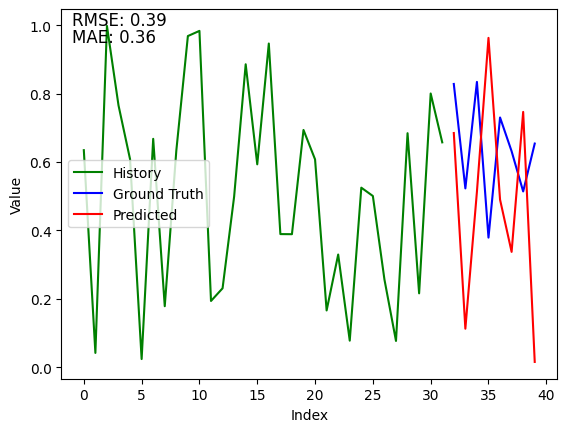

In [33]:
f = plot_results(seq_datapoint, 8, 32)